## **PAYMENT INCIDENT RATE - COHORT ANALYSIS**

In [45]:
#Importing the required libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [46]:
#Importing the different datasets

cash = pd.read_csv('project_dataset/cash-clean.csv')
fees = pd.read_csv('project_dataset/fees-clean.csv')

#### **UNDERSTANDIG DATA**

In this analysis we are going to calculate the payment incident rate. After reading de Lexique of our datasets, we understand as payment incident rate, the percentage of incidents that users have when doing the reimbursement of the cash request to Ironhack Payments. Through an exploratory data process and the comprehension of the lexique, we arrived to the conclusion that a payment incident is generated when the reimbursement_date expires and the user have not returned the money back.    


In [47]:
#We can observe that when the status of the cash request is 'money back', all payment incident status('recovery_status') are completed.
cash[(cash['status']=='money_back')]['recovery_status'].value_counts()

recovery_status
completed    2460
Name: count, dtype: int64

In [48]:
#These are examples that make us deduce that the reco_creation date, i.e. the date of the payment incident, is generated when not giving back money
#before the reimbursement_date expires.
cash[(cash['recovery_status']=='completed')].head()

,Unnamed: 0,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
5,5,2145,100.0,money_back,2020-05-23 20:58:55.129432+00:00,2020-07-06 03:36:03.023911+00,9489.0,2020-05-24 12:40:33.05491+00,NaN,2020-06-06 22:00:00+00:00,2020-05-26,2020-07-06 03:36:03.023521+00,regular,NaN,completed,2020-06-12 22:27:04.837525+00:00,2020-07-06 03:36:03.030904+00:00
11,11,1794,100.0,money_back,2020-05-14 21:11:47.393326+00:00,2020-06-03 05:11:35.312872+00,778.0,2020-05-15 09:11:17.272832+00,NaN,2020-05-29 21:11:46.695000+00:00,2020-05-17,2020-06-03 05:11:35.312616+00,regular,NaN,completed,2020-05-29 21:21:01.362364+00:00,2020-06-03 05:11:35.319122+00:00
72,72,2271,100.0,money_back,2020-05-28 23:21:24.988386+00:00,2020-09-18 07:45:25.74754+00,10503.0,2020-05-29 07:40:54.629978+00,NaN,2020-06-08 22:00:00+00:00,2020-06-01,2020-09-18 07:45:25.740402+00,regular,NaN,completed,2020-06-12 22:30:08.558561+00:00,2020-09-18 07:45:25.761696+00:00
84,84,898,100.0,money_back,2020-03-16 16:15:53.191521+00:00,2020-04-22 08:21:37.993909+00,4411.0,2020-03-16 16:42:11.07247+00,NaN,2020-04-15 16:15:53.191192+00:00,2020-03-26,2020-04-22 08:21:37.993696+00,regular,NaN,completed,2020-04-15 20:50:30.312191+00:00,2020-04-22 08:21:38.000390+00:00
217,217,1199,100.0,money_back,2020-04-15 12:36:21.976740+00:00,2020-05-05 12:14:02.731733+00,6272.0,2020-04-15 16:03:08.272578+00,NaN,2020-04-22 12:36:21.976265+00:00,2020-04-18,2020-05-05 12:14:02.731562+00,regular,NaN,completed,2020-04-27 08:06:03.944358+00:00,2020-05-05 12:14:02.736633+00:00


#### **COHORT ANALYSIS**

In [49]:
#Creating a subset with the necessary columns only
cash_cohort = cash[['id','user_id','status','created_at','deleted_account_id','recovery_status','reco_creation','reimbursement_date','transfer_type']]
cash_cohort
#We are going to filter our data with user_id's which received the cash request, in order to calculate the  payment incident rate over these users. 
#For us, does not make sense to calculate the rate over status as rejected or pending for example, because we don't know yet if they are gonna have a payment incident
cash_cohort= cash_cohort[(cash_cohort['status']=='active') | (cash_cohort['status']=='money_back')]
cash_cohort

#As reco_creation is null if the cash request never had a payment incident, we fill it with 'reimbursement_date' for user_ids with no incident payments because we assume they paid in time.
cash_cohort['reco_creation'] = cash_cohort['reco_creation'].fillna(cash_cohort['reimbursement_date'])
cash_cohort
#Make sure no more missing user_ids
cash_cohort[cash_cohort['reco_creation'].isna()]

,id,user_id,status,created_at,deleted_account_id,recovery_status,reco_creation,reimbursement_date,transfer_type


In [50]:
#Dropping columns we no longer need:
cash_cohort = cash_cohort.drop('deleted_account_id', axis='columns')

cash_cohort = cash_cohort.drop('reimbursement_date', axis='columns')

cash_cohort = cash_cohort.drop('status', axis='columns')


In [51]:
#We transform the variable 'created_at' to datetime
cash_cohort['created_at'] = pd.to_datetime(cash_cohort['created_at'])
cash_cohort['reco_creation'] = pd.to_datetime(cash_cohort['reco_creation'],format='ISO8601')

#We create the cohort group by considering the first cash request creation date for each user_id, and transform to 'yyyy-mm' format
cash_cohort['cohort group'] = cash_cohort.groupby('user_id')['created_at'].transform('min').dt.to_period('M') 

#We transform 'reco_creation' into the same 'yyyy-mm'format.
cash_cohort['reco_creation'] = cash_cohort['reco_creation'].dt.to_period('M')  

cash_cohort

/tmp/ipykernel_241262/4169273816.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_cohort['cohort group'] = cash_cohort.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
/tmp/ipykernel_241262/4169273816.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_cohort['reco_creation'] = cash_cohort['reco_creation'].dt.to_period('M')


,id,user_id,created_at,recovery_status,reco_creation,transfer_type,cohort group
5,2145,9489.0,2020-05-23 20:58:55.129432+00:00,completed,2020-06,regular,2020-05
11,1794,778.0,2020-05-14 21:11:47.393326+00:00,completed,2020-05,regular,2019-12
13,2122,8218.0,2020-05-22 12:47:42.741369+00:00,NaN,2020-06,regular,2020-04
43,1629,9068.0,2020-05-08 11:02:44.881355+00:00,NaN,2020-06,regular,2020-05
48,23534,21465.0,2020-10-23 15:20:26.163927+00:00,NaN,2020-11,instant,2020-10
...,...,...,...,...,...,...,...
23964,16834,20064.0,2020-09-19 07:37:14.351567+00:00,completed,2020-10,instant,2020-06
23965,20616,13681.0,2020-10-12 13:54:11.686225+00:00,NaN,2021-02,instant,2020-06
23966,25243,30367.0,2020-10-27 14:41:25.734910+00:00,completed,2020-11,instant,2020-10
23967,22357,82122.0,2020-10-20 07:58:04.006937+00:00,NaN,2021-02,instant,2020-10


In [52]:
#Getting unique user_id
cash_cohort.groupby(['cohort group'])['user_id'].nunique()

cohort group
2019-12     147
2020-01      52
2020-02      64
2020-03      71
2020-04     173
2020-05     352
2020-06    1113
2020-07     930
2020-08     494
2020-09    1273
2020-10    4661
2020-11      75
Freq: M, Name: user_id, dtype: int64

In [53]:
#Getting total cash requests by cohort group to compare with unique users
total_cash_requests=cash_cohort.groupby(['cohort group'])['id'].count()
total_cash_requests

cohort group
2019-12     604
2020-01     203
2020-02     343
2020-03     286
2020-04     615
2020-05    1201
2020-06    3289
2020-07    2265
2020-08     950
2020-09    1810
2020-10    4815
2020-11      75
Freq: M, Name: id, dtype: int64

In [54]:
#Calculating the number of cash requests with payment incidents by cohort group and reco_creation date
incident_cohort = cash_cohort.groupby(['cohort group', 'reco_creation'])['recovery_status'].count().reset_index()
incident_cohort

,cohort group,reco_creation,recovery_status
0,2019-12,2019-12,0
1,2019-12,2020-01,0
2,2019-12,2020-02,0
3,2019-12,2020-03,18
4,2019-12,2020-04,13
...,...,...,...
103,2020-10,2021-03,0
104,2020-11,2020-11,7
105,2020-11,2020-12,4
106,2020-11,2021-01,0


In [55]:
#Creating a pivot table to show the results
incident_pivot = incident_cohort.pivot(index='cohort group', columns='reco_creation', values='recovery_status')
incident_pivot

reco_creation,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
cohort group,,,,,,,,,,,,,,,,
2019-12,0.0,0.0,0.0,18.0,13.0,5.0,9.0,10.0,3.0,7.0,5.0,4.0,0.0,NaN,NaN,NaN
2020-01,NaN,0.0,0.0,8.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0,0.0,NaN,NaN,NaN
2020-02,NaN,NaN,0.0,2.0,3.0,4.0,4.0,4.0,1.0,5.0,3.0,3.0,NaN,NaN,NaN,NaN
2020-03,NaN,NaN,NaN,0.0,10.0,5.0,5.0,5.0,3.0,4.0,3.0,2.0,1.0,NaN,0.0,NaN
2020-04,NaN,NaN,NaN,NaN,5.0,21.0,22.0,16.0,10.0,7.0,8.0,6.0,0.0,NaN,NaN,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,4.0,45.0,44.0,38.0,22.0,23.0,15.0,1.0,0.0,0.0,NaN
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,3.0,114.0,136.0,60.0,103.0,59.0,12.0,2.0,0.0,0.0
2020-07,NaN,NaN,NaN,NaN,0.0,NaN,NaN,7.0,129.0,75.0,99.0,54.0,9.0,4.0,0.0,NaN
2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,51.0,71.0,21.0,11.0,2.0,0.0,NaN


In [56]:
#Calculating the TOTAL number of cash requests (with incidents and not) by cohort group and reco_creation date and pivoting the results
total_cohort = cash_cohort.groupby(['cohort group', 'reco_creation'])['id'].count().reset_index()

incident_pivot_month = total_cohort.pivot(index='cohort group', columns='reco_creation', values='id') 
incident_pivot_month

reco_creation,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
cohort group,,,,,,,,,,,,,,,,
2019-12,34.0,94.0,36.0,64.0,60.0,56.0,45.0,49.0,42.0,36.0,43.0,44.0,1.0,NaN,NaN,NaN
2020-01,NaN,2.0,12.0,29.0,29.0,21.0,18.0,20.0,18.0,16.0,19.0,15.0,4.0,NaN,NaN,NaN
2020-02,NaN,NaN,21.0,45.0,40.0,36.0,31.0,36.0,36.0,30.0,39.0,29.0,NaN,NaN,NaN,NaN
2020-03,NaN,NaN,NaN,17.0,59.0,37.0,29.0,38.0,29.0,20.0,33.0,20.0,3.0,NaN,1.0,NaN
2020-04,NaN,NaN,NaN,NaN,25.0,162.0,89.0,86.0,73.0,56.0,58.0,57.0,9.0,NaN,NaN,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,65.0,271.0,227.0,194.0,160.0,148.0,124.0,9.0,2.0,1.0,NaN
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,116.0,841.0,729.0,531.0,560.0,434.0,49.0,18.0,10.0,1.0
2020-07,NaN,NaN,NaN,NaN,1.0,NaN,NaN,145.0,691.0,491.0,491.0,388.0,43.0,11.0,4.0,NaN
2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,350.0,294.0,218.0,25.0,8.0,1.0,NaN


In [57]:
#We find this mistake with a reimbursement_date before the creation cash_request_date
cash_cohort[(cash_cohort['cohort group']=='2020-07') & (cash_cohort['reco_creation']=='2020-04')]

,id,user_id,created_at,recovery_status,reco_creation,transfer_type,cohort group
13689,8626,33881.0,2020-07-17 10:37:54.852063+00:00,NaN,2020-04,regular,2020-07


In [58]:
cash[cash['user_id'] == 33881.0]

,Unnamed: 0,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
13689,13689,8626,60.0,money_back,2020-07-17 10:37:54.852063+00:00,2020-12-18 13:09:54.18426+00,33881.0,2020-07-17 15:47:55+00,NaN,2020-04-03 22:00:00+00:00,2020-07-21,2020-07-29 00:53:41.172353+00,regular,NaN,NaN,NaN,NaN
17063,17063,17300,50.0,money_back,2020-09-22 14:51:37.303385+00:00,2020-12-18 13:11:08.959071+00,33881.0,2020-09-22 16:48:48+00,NaN,2020-10-16 14:51:37+00:00,2020-09-24,NaN,instant,2020-10-06 14:51:37+00,NaN,NaN,NaN
23775,23775,26170,50.0,money_back,2020-10-29 17:18:50.735027+00:00,2020-12-18 13:16:19.639268+00,33881.0,2020-10-30 09:47:03.513439+00,NaN,2020-11-29 23:00:00+00:00,2020-10-31,2020-12-03 23:00:00+00,instant,2020-10-29 17:19:03.957979+00,NaN,NaN,NaN


In [59]:
incident_pivot_month= incident_pivot_month.fillna(0) #filling specific spots with 0 to differentiate actual 0s to no data yet  
incident_pivot_month.loc['2020-07','2020-04'] = 0 #Solving the mistake detected before

incident_pivot_month

reco_creation,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
cohort group,,,,,,,,,,,,,,,,
2019-12,34.0,94.0,36.0,64.0,60.0,56.0,45.0,49.0,42.0,36.0,43.0,44.0,1.0,0.0,0.0,0.0
2020-01,0.0,2.0,12.0,29.0,29.0,21.0,18.0,20.0,18.0,16.0,19.0,15.0,4.0,0.0,0.0,0.0
2020-02,0.0,0.0,21.0,45.0,40.0,36.0,31.0,36.0,36.0,30.0,39.0,29.0,0.0,0.0,0.0,0.0
2020-03,0.0,0.0,0.0,17.0,59.0,37.0,29.0,38.0,29.0,20.0,33.0,20.0,3.0,0.0,1.0,0.0
2020-04,0.0,0.0,0.0,0.0,25.0,162.0,89.0,86.0,73.0,56.0,58.0,57.0,9.0,0.0,0.0,0.0
2020-05,0.0,0.0,0.0,0.0,0.0,65.0,271.0,227.0,194.0,160.0,148.0,124.0,9.0,2.0,1.0,0.0
2020-06,0.0,0.0,0.0,0.0,0.0,0.0,116.0,841.0,729.0,531.0,560.0,434.0,49.0,18.0,10.0,1.0
2020-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,691.0,491.0,491.0,388.0,43.0,11.0,4.0,0.0
2020-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,350.0,294.0,218.0,25.0,8.0,1.0,0.0


#After the detected mistake of a reimbursement_date before the creation cash_request_date, we are going to clean our data to be sure the are not other
hidden mistakes.

In [60]:
cash[(cash['created_at']>cash['reimbursement_date'])]

,Unnamed: 0,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
13689,13689,8626,60.0,money_back,2020-07-17 10:37:54.852063+00:00,2020-12-18 13:09:54.18426+00,33881.0,2020-07-17 15:47:55+00,NaN,2020-04-03 22:00:00+00:00,2020-07-21,2020-07-29 00:53:41.172353+00,regular,NaN,NaN,NaN,NaN


#We can see that it was an isolated case, may be, as the there is one cash request status of 'waiting_reimbursement' which means that Ironhack was not able to estimate a date of reimbursement and is the user who needs to choose one in the app, it was an error of introducing the date by the user.
#We would recommend Ironhack payments to always check this date because can derive in a problem of not receiving money back.

In [61]:
#We calculate the incident payment rate, the portion of incidents over the total of payments.
incident_pivot = incident_pivot.div(incident_pivot_month, axis=0)
incident_pivot

reco_creation,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03
cohort group,,,,,,,,,,,,,,,,
2019-12,0.0,0.0,0.0,0.281250,0.216667,0.089286,0.200000,0.204082,0.071429,0.194444,0.116279,0.090909,0.000000,NaN,NaN,NaN
2020-01,NaN,0.0,0.0,0.275862,0.103448,0.142857,0.111111,0.100000,0.111111,0.125000,0.052632,0.266667,0.000000,NaN,NaN,NaN
2020-02,NaN,NaN,0.0,0.044444,0.075000,0.111111,0.129032,0.111111,0.027778,0.166667,0.076923,0.103448,NaN,NaN,NaN,NaN
2020-03,NaN,NaN,NaN,0.000000,0.169492,0.135135,0.172414,0.131579,0.103448,0.200000,0.090909,0.100000,0.333333,NaN,0.0,NaN
2020-04,NaN,NaN,NaN,NaN,0.200000,0.129630,0.247191,0.186047,0.136986,0.125000,0.137931,0.105263,0.000000,NaN,NaN,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,0.061538,0.166052,0.193833,0.195876,0.137500,0.155405,0.120968,0.111111,0.000000,0.0,NaN
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,0.025862,0.135553,0.186557,0.112994,0.183929,0.135945,0.244898,0.111111,0.0,0.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048276,0.186686,0.152749,0.201629,0.139175,0.209302,0.363636,0.0,NaN
2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055556,0.145714,0.241497,0.096330,0.440000,0.250000,0.0,NaN


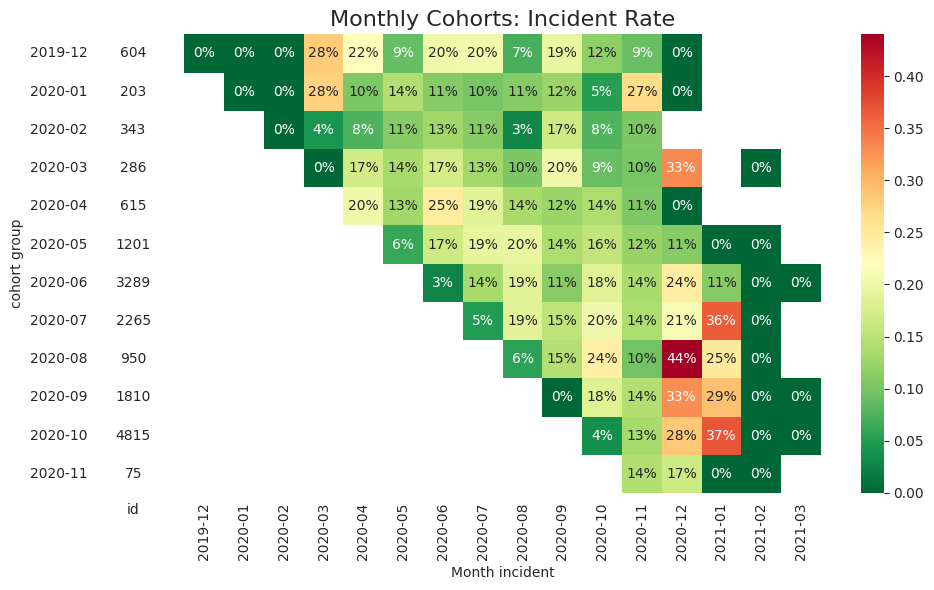

In [62]:
#Showing the results in a graph
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # heatmap for incident cohort analysis
    sns.heatmap(incident_pivot, 
                mask=incident_pivot.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn_r', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Incident Rate', fontsize=16)
    ax[1].set(xlabel='Month incident',
              ylabel='')
    
    # This is where I include the total number of users so we have it in the graph as well
    cohort_size_df = pd.DataFrame(total_cash_requests).rename(columns={0: 'Months passed'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    

#### **RESULTS INTERPRETATION**


We observe that cash requests from users in cohort groups from summer 2020 started having a higher payment incident rate.
We are going to try to understand the reason. For that, we are going to use the transfer_type variable because we saw in the Exploratory Data Analysis that instant payments had more completed incidents.

In [63]:
type_incident_cohort = cash_cohort.groupby(['cohort group','transfer_type'])['recovery_status'].count().reset_index()
type_incident_cohort

,cohort group,transfer_type,recovery_status
0,2019-12,instant,14
1,2019-12,regular,60
2,2020-01,instant,6
3,2020-01,regular,21
4,2020-02,instant,8
5,2020-02,regular,21
6,2020-03,instant,9
7,2020-03,regular,29
8,2020-04,instant,19
9,2020-04,regular,76


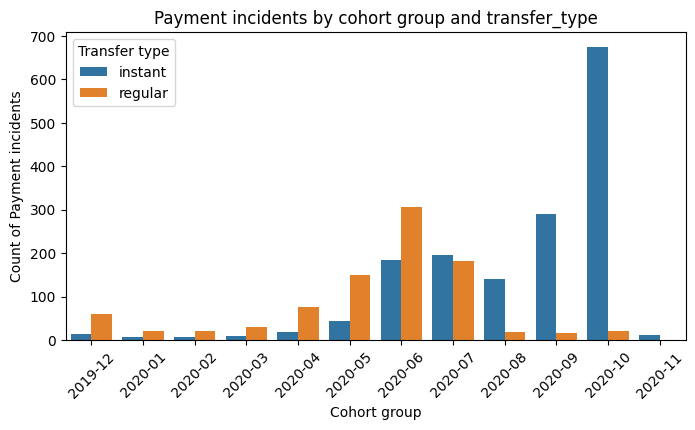

In [64]:
#Creating a barplot to understand the results
plt.figure(figsize=(8, 4))
sns.barplot(data=type_incident_cohort, x='cohort group', y='recovery_status', hue='transfer_type')

plt.title('Payment incidents by cohort group and transfer_type')
plt.xlabel('Cohort group')
plt.ylabel('Count of Payment incidents')
plt.xticks(rotation=45) 

plt.legend(title='Transfer type')
plt.show()

 As we can see, before summer 2020 the number of regular payments were higher than instant payments. A possible explanation we deduce from data is that IronhackPayments, during COVID-19, decided to launch a marketing campaing promoting instant payments in order to get higher fees (as instant cash requests involve fees) in order to get higher profits. 
 The number of cash requets increased due to the campaing, which implied that when the reimbursement date expired, a higher number of users generated an incident payment. 

 